In [63]:
import pickle


def l2norm(list1, list2):
    l2_norm_difference = sum((x - y) ** 2 for x, y in zip(list1, list2)) ** 0.5
    l2_norm_reference = sum(y**2 for y in list1) ** 0.5
    return l2_norm_difference / l2_norm_reference


def get_record(cnum, dataset, model, setup):
    rec_path = f"./rec_fed_sample_time/{model}_model_{cnum}_{dataset}_{setup}.rec"
    with open(rec_path, "rb") as res_file:
        record = pickle.load(res_file)
    return record


def get_result(cnum, dataset, model, setup):
    res_path = f"./expres/{model}_model_{cnum}_{dataset}_{setup}.res"
    with open(res_path, "rb") as res_file:
        result = pickle.load(res_file)
    return result["Comb-Shapley"][0], result

In [64]:
import os
import sys

from tqdm import tqdm
from helper_alg import IPSS_SHAP, TMC_SHAP, GTB_SHAP, CC_SHAP

cnum = 10
dataset = "emnist"
model = "linear"
setup = "same"
setting = (cnum, dataset, model, setup)

record = get_record(cnum, dataset, model, setup)
exact, result = get_result(cnum, dataset, model, setup)
sample_algs = {"Light Sampling": IPSS_SHAP, "Extended-TMC": TMC_SHAP, "Extended-GTB": GTB_SHAP, "CC-Shapley": CC_SHAP}
data_filepath = f"data/data_{cnum}_{model}_{dataset}_{setup}.pk"
data = {}

if os.path.exists(data_filepath):
    with open(data_filepath, "rb") as data_file:
        data = pickle.load(data_file)
else:
    for alg in result:
        if alg in sample_algs:
            tmp = []
            error = []
            for gamma in tqdm(range(1, 2**cnum + 1), desc=alg):
                try:
                    acc, loss, acc_time, loss_time = sample_algs[alg](record, cnum, gamma, False)
                    tmp.append((gamma, acc_time, l2norm(exact, acc)))
                except:
                    error.append(gamma)
            if error:
                print(f"Error in {alg} for gamma = {error}")
            data[alg] = tmp
        else:
            data[alg] = (result[alg][1], l2norm(exact, result[alg][0]))
    with open(data_filepath, "wb") as f:
        pickle.dump(data, f)

non_sample_algs = [alg for alg in data if alg not in sample_algs]

data

{'Comb-Shapley': (95985.88317975379, 0.0),
 'Perm-Shapley': (6801576198.087346, 1.2101327109216153e-11),
 'Extended-TMC': [(1, 167.42106314375997, 1.0),
  (2, 167.42106314375997, 1.0),
  (3, 167.42106314375997, 1.0),
  (4, 167.42106314375997, 1.0),
  (5, 167.42106314375997, 1.0),
  (6, 167.42106314375997, 1.0),
  (7, 167.42106314375997, 1.0),
  (8, 167.42106314375997, 1.0),
  (9, 167.42106314375997, 1.0),
  (10, 1161.7524946574122, 5.403968332461122),
  (11, 1211.792292971164, 4.028512529655335),
  (12, 1169.6843950357288, 5.3554706936325855),
  (13, 1148.4019661396742, 2.5496859100983023),
  (14, 1162.1886827014387, 2.695426564516517),
  (15, 1173.9429225642234, 3.7006629779094538),
  (16, 1153.0615780577064, 4.064676989155473),
  (17, 1170.445719530806, 3.9192887123442075),
  (18, 1176.9920491483063, 5.88310096512775),
  (19, 1134.046587124467, 3.270874689360577),
  (20, 2174.451859615743, 3.747165792308635),
  (21, 2183.095373703167, 2.7702992381135108),
  (22, 2271.0398715101182, 3

In [65]:
import matplotlib.pylab as plt

# plt.style.use("ggplot")
# plt.rcParams["axes.prop_cycle"]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"

In [66]:
import math
import numpy as np


def remove_local_outliers(data, window_size=5, threshold=3):
    """使用滑动窗口的中位数绝对偏差 (MAD) 过滤局部离群点"""
    data = np.array(data)
    filtered_data = data.copy()

    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        window = data[start:end]

        median = np.median(window)
        mad = np.median(np.abs(window - median))  # 计算 MAD

        # 过滤超出 threshold * MAD 的点
        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = np.nan  # 设为 NaN，稍后删除

    return filtered_data[~np.isnan(filtered_data)]  # 移除 NaN 作为离群点


def log_func(x, a, b, c):
    return a * np.log(c * x) + b


def inv_func(x, a, b):
    return a / x + b


FUNC = "log"
fit_func = {"log": log_func, "inv": inv_func}[FUNC]

scale = 1e4
if setting == (6, "emnist", "linear", "same"):
    scale = 2e3
elif setting == (6, "emnist", "cnn", "same"):
    scale = 1e3
elif setting == (3, "emnist", "linear", "same"):
    scale = 200
elif setting == (3, "emnist", "cnn", "same"):
    scale = 100
# tot_time = int(math.ceil(data["Comb-Shapley"][0] / scale) * scale)
tot_time = int(data["Comb-Shapley"][0])
# tot_time = int(math.floor(data["Comb-Shapley"][0] / scale) * scale)

perm_xy = {
    (3, "emnist", "linear", "same"): "($\mathrm{4\\times 10^3}$, 0)",
    (3, "emnist", "cnn", "same"): "($\mathrm{2\\times 10^3}$, 0)",
    (6, "emnist", "linear", "same"): "($\mathrm{9\\times 10^5}$, 0)",
    (6, "emnist", "cnn", "same"): "($\mathrm{4\\times 10^5}$, 0)",
    (10, "adult", "linear", "same"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "emnist", "linear", "same"): "($\mathrm{7\\times 10^9}$, 0)",
    (10, "mnist", "linear", "same"): "($\mathrm{6\\times 10^8}$, 0)",
    (10, "mnist", "linear", "mixDtr"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "mnist", "linear", "mixSize"): "($\mathrm{6\\times 10^8}$, 0)",
    (10, "mnist", "linear", "noiseX"): "($\mathrm{6\\times 10^8}$, 0)",
    (10, "mnist", "linear", "noiseY"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "emnist", "cnn", "same"): "($\mathrm{3\\times 10^9}$, 0)",
    (10, "mnist", "cnn", "same"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "mnist", "cnn", "mixDtr"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "mnist", "cnn", "mixSize"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "mnist", "cnn", "noiseX"): "($\mathrm{2\\times 10^9}$, 0)",
    (10, "mnist", "cnn", "noiseY"): "($\mathrm{2\\times 10^9}$, 0)",
}

with open(data_filepath, "rb") as data_file:
    data = pickle.load(data_file)


def filter_begin(c, d, m, s, *pairs):
    if setting == (c, d, m, s):
        for alg, begin in pairs:
            data[alg] = data[alg][begin:]


filter_begin(6, "emnist", "cnn", "same", ("Light Sampling", 18), ("CC-Shapley", 6))
filter_begin(10, "emnist", "cnn", "same", ("Light Sampling", 10), ("CC-Shapley", 15))

filter_begin(10, "adult", "linear", "same", ("Light Sampling", 5))
filter_begin(10, "mnist", "linear", "mixDtr", ("Light Sampling", 10), ("CC-Shapley", 15))
filter_begin(10, "mnist", "linear", "mixSize", ("Light Sampling", 10), ("CC-Shapley", 15))
filter_begin(10, "mnist", "linear", "noiseX", ("Light Sampling", 10), ("CC-Shapley", 15))
filter_begin(10, "mnist", "linear", "noiseY", ("Light Sampling", 15), ("CC-Shapley", 10))
filter_begin(10, "mnist", "cnn", "same", ("Light Sampling", 10), ("CC-Shapley", 10))
filter_begin(10, "mnist", "cnn", "mixDtr", ("Light Sampling", 15), ("CC-Shapley", 10))
filter_begin(10, "mnist", "cnn", "mixSize", ("Light Sampling", 10), ("CC-Shapley", 10))
filter_begin(10, "mnist", "cnn", "noiseX", ("Light Sampling", 10), ("CC-Shapley", 15))
filter_begin(10, "mnist", "cnn", "noiseY", ("Light Sampling", 25), ("CC-Shapley", 10))


C:\Users\t0ush1\AppData\Local\Temp\ipykernel_22908\3222337848.py:26: RuntimeWarning: invalid value encountered in log
  return a * np.log(c * x) + b


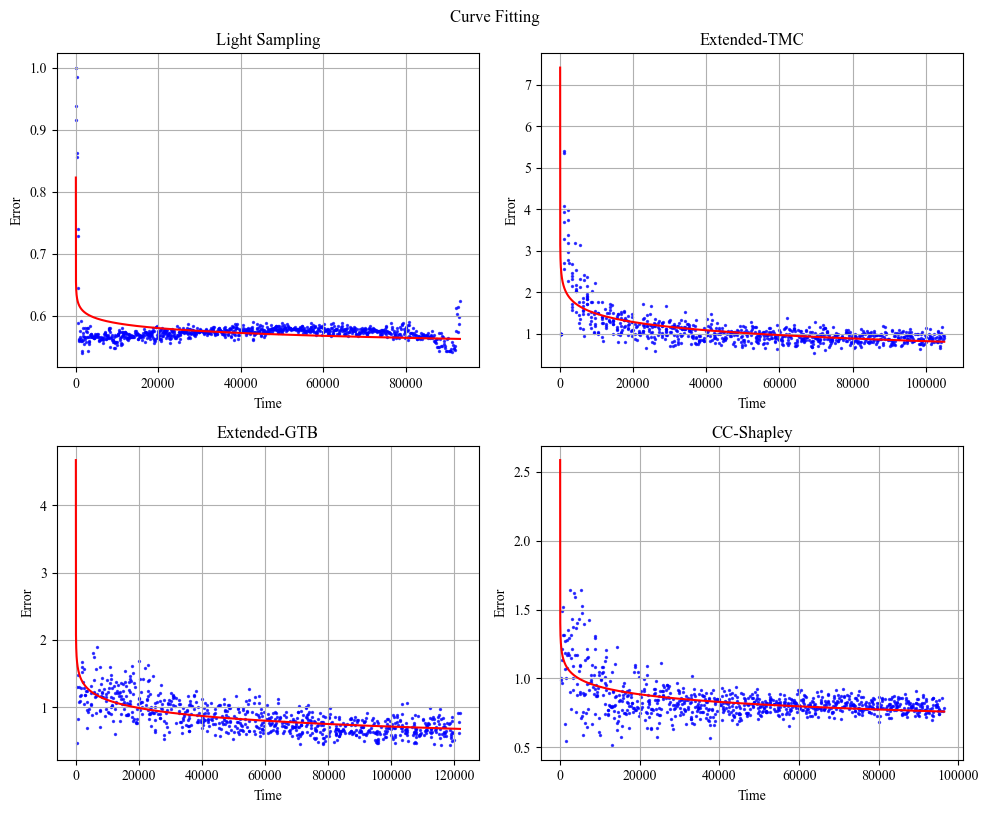

In [67]:
from matplotlib.axes import Axes
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
algorithms = list(sample_algs.keys())

for i, ax in enumerate(axes.flat):
    ax: Axes

    tmp = np.array(data[algorithms[i]])
    time = tmp[:, 1]
    error = tmp[:, 2]

    if cnum >= 6:
        time_filtered = remove_local_outliers(time)
        error_filtered = remove_local_outliers(error)
        mask_time = np.isin(time, time_filtered)
        mask_error = np.isin(error, error_filtered)
        mask = mask_time & mask_error
        time = time[mask]
        error = error[mask]

    sorted_indices = np.argsort(time)
    time = time[sorted_indices]
    error = error[sorted_indices]

    popt, _ = curve_fit(fit_func, time, error)

    x = np.linspace(1e-5, max(time), num=int(max(time)))
    y_fit = fit_func(x, *popt)

    ax.scatter(time, error, s=2, color="blue", alpha=0.7)
    ax.plot(x, y_fit, color="red")
    ax.set_title(algorithms[i])
    ax.set_xlabel("Time")
    ax.set_ylabel("Error")
    ax.grid()

fig.tight_layout()
plt.suptitle("Curve Fitting", y=1.01)
plt.show()

C:\Users\t0ush1\AppData\Local\Temp\ipykernel_22908\3222337848.py:26: RuntimeWarning: invalid value encountered in log
  return a * np.log(c * x) + b


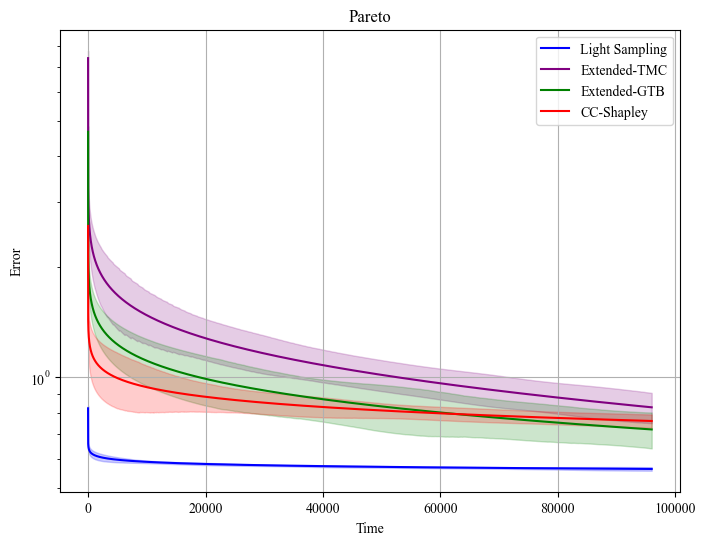

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d


def compute_local_std(x, y, k=20):
    """计算每个 x 点附近 k 个点的局部标准差"""
    tree = KDTree(x.reshape(-1, 1))
    local_std = np.zeros_like(x)

    for i, xi in enumerate(x):
        _, idx = tree.query(xi, k=k)  # 取最近 k 个点
        local_std[i] = np.std(y[idx])  # 计算局部标准差

    return local_std


plt.figure(figsize=(8, 6))
colors = ["blue", "purple", "green", "red"]

algorithms = list(sample_algs.keys())
for i, alg in enumerate(algorithms):
    if isinstance(data[alg], list):
        tmp = np.array(data[alg])
        time, error = tmp[:, 1], tmp[:, 2]

        # 过滤离群点
        if cnum >= 6:
            time_filtered = remove_local_outliers(time)
            error_filtered = remove_local_outliers(error)
            mask_time = np.isin(time, time_filtered)
            mask_error = np.isin(error, error_filtered)
            mask = mask_time & mask_error
            time = time[mask]
            error = error[mask]

        # 排序
        sorted_indices = np.argsort(time)
        time, error = time[sorted_indices], error[sorted_indices]

        # 拟合
        popt, _ = curve_fit(fit_func, time, error)
        x = np.linspace(1e-5, tot_time, num=tot_time)
        y_fit = fit_func(x, *popt)

        # 计算局部标准差，平滑插值（time 到 x）
        y_local_std = compute_local_std(time, error, k=3)
        # spline = UnivariateSpline(time, y_local_std, s=3)  # s 控制平滑程度
        # y_interp_std = spline(x)
        y_smooth_std = gaussian_filter1d(y_local_std, sigma=50)  # sigma 控制平滑程度
        y_interp_std = np.interp(x, time, y_smooth_std)
        # y_interp_std = np.maximum(y_interp_std, 0)
        y_upper = y_fit + y_interp_std
        y_lower = y_fit - y_interp_std

        # 绘制拟合曲线和范围
        plt.plot(x, y_fit, color=colors[i], label=alg)
        plt.fill_between(x, y_lower, y_upper, color=colors[i], alpha=0.2)

plt.yscale("log")
plt.title("Pareto")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

C:\Users\t0ush1\AppData\Local\Temp\ipykernel_22908\3222337848.py:26: RuntimeWarning: invalid value encountered in log
  return a * np.log(c * x) + b


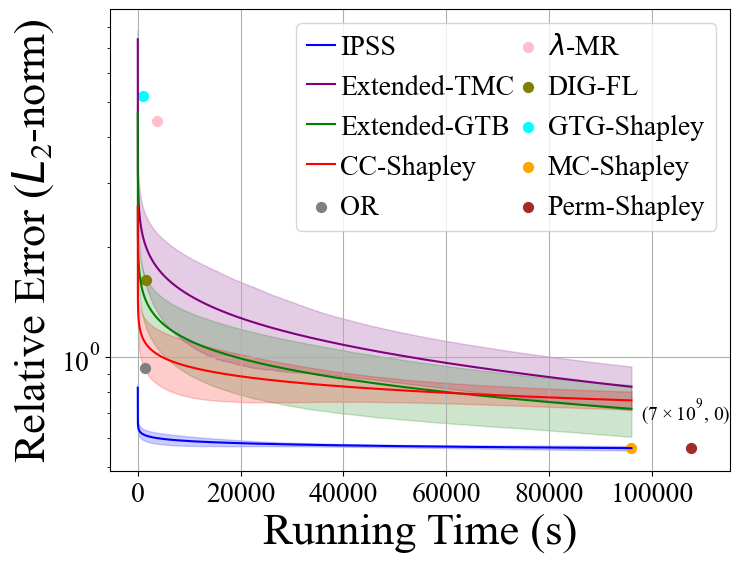

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fontsize = 32
labelsize = 20
labels = {
    "Light Sampling": "IPSS",
    "$lambda$-MR": "$\lambda$-MR",
    "Comb-Shapley": "MC-Shapley",
}

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

algs = list(sample_algs.keys()) + non_sample_algs
colors = ["blue", "purple", "green", "red", "orange", "brown", "gray", "pink", "olive", "cyan"]
linthresh = 1e5

for i, alg in enumerate(algs):
    if alg == "Perm-Shapley" or alg == "Comb-Shapley":
        if alg == "Comb-Shapley":
            comb_idx = i
        elif alg == "Perm-Shapley":
            perm_idx = i
        continue
    if isinstance(data[alg], list):
        tmp = np.array(data[alg])
        time, error = tmp[:, 1], tmp[:, 2]

        if cnum >= 6:
            time_filtered = remove_local_outliers(time)
            error_filtered = remove_local_outliers(error)
            mask_time = np.isin(time, time_filtered)
            mask_error = np.isin(error, error_filtered)
            mask = mask_time & mask_error
            time = time[mask]
            error = error[mask]

        sorted_indices = np.argsort(time)
        time, error = time[sorted_indices], error[sorted_indices]

        popt, _ = curve_fit(fit_func, time, error)
        x = np.linspace(1e-5, tot_time, num=tot_time)
        y_fit = fit_func(x, *popt)

        y_local_std = compute_local_std(time, error, k=30) # 30 3
        y_smooth_std = gaussian_filter1d(y_local_std, sigma=150) # 150 20
        y_interp_std = np.interp(x, time, y_smooth_std)
        y_upper = y_fit + y_interp_std
        y_lower = y_fit - y_interp_std

        ax.plot(x, y_fit, color=colors[i], label=labels.get(alg, alg))
        ax.fill_between(x, y_lower, y_upper, color=colors[i], alpha=0.2)

        linthresh = min(min(y_fit), linthresh)
    else:
        ax.scatter(data[alg][0], data[alg][1], color=colors[i], s=50, label=labels.get(alg, alg))

alg = algs[comb_idx]
ax.scatter(data[alg][0], linthresh, color=colors[comb_idx], s=50, label=labels.get(alg, alg))
alg = algs[perm_idx]
ax.scatter(tot_time * 1.12, linthresh, color=colors[perm_idx], s=50, label=labels.get(alg, alg))
ax.annotate(perm_xy[setting], xy=(tot_time * 1.02, linthresh * 1.2), fontsize=14)

# plt.yscale("symlog", linthresh=linthresh)
plt.yscale("log")
plt.xlim(right=tot_time * 1.2)

if setting == (10, "emnist", "cnn", "same"):
    ax.set_yticks([1e-2, 1e-1, 1e0, 1e1])
if setting == (6, "emnist", "cnn", "same"):
    ax.set_yticks([1e-2, 1e-1, 1e0])

# plt.title(f"Pareto ({dataset})")
plt.xlabel("Running Time (s)", fontsize=fontsize)
plt.ylabel("Relative Error ($L_{2}$-norm)", fontsize=fontsize)
plt.tick_params(axis="both", labelsize=labelsize)
legend = plt.legend(loc="upper right", ncol=2, columnspacing=0, handletextpad=0.2, handlelength=1, fontsize=labelsize)
plt.grid()
plt.savefig(f"figs/pareto/pareto_{cnum}_{model}_{dataset}_{setup}.png", bbox_inches="tight")
plt.show()

In [70]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.interpolate import UnivariateSpline
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# fontsize = 32
# labelsize = 20
# labels = {
#     "Light Sampling": "IPSS",
#     "$lambda$-MR": "$\lambda$-MR",
#     "Comb-Shapley": "MC-Shapley",
# }

# fig = plt.figure(figsize=(8, 6))
# ax = plt.gca()

# algs = list(sample_algs.keys()) + non_sample_algs
# colors = ["blue", "purple", "green", "red", "orange", "brown", "gray", "pink", "olive", "cyan"]
# linthresh = 1e5

# for i, alg in enumerate(algs):
#     if alg == "Perm-Shapley" or alg == "Comb-Shapley":
#         if alg == "Comb-Shapley":
#             comb_idx = i
#         elif alg == "Perm-Shapley":
#             perm_idx = i
#         continue
#     if isinstance(data[alg], list):
#         tmp = np.array(data[alg])
#         time, error = tmp[:, 1], tmp[:, 2]

#         sorted_indices = np.argsort(time)
#         time, error = time[sorted_indices], error[sorted_indices]

#         popt, _ = curve_fit(fit_func, time, error)
#         x = np.linspace(1e-3, tot_time, num=tot_time) # 1e-3 1e-1
#         y_fit = fit_func(x, *popt)

#         y_local_std = compute_local_std(time, error, k=3)
#         y_smooth_std = gaussian_filter1d(y_local_std, sigma=3)
#         y_interp_std = np.interp(x, time, y_smooth_std)
#         y_upper = y_fit + y_interp_std
#         y_lower = y_fit - y_interp_std

#         ax.plot(x, y_fit, color=colors[i], label=labels.get(alg, alg))
#         ax.fill_between(x, y_lower, y_upper, color=colors[i], alpha=0.2)

#         linthresh = min(min(y_lower), linthresh)
#     else:
#         ax.scatter(data[alg][0], data[alg][1], color=colors[i], s=50, label=labels.get(alg, alg))

# alg = algs[comb_idx]
# ax.scatter(data[alg][0], 0, color=colors[comb_idx], s=50, label=labels.get(alg, alg))
# alg = algs[perm_idx]
# ax.scatter(tot_time * 1.15, 0, color=colors[perm_idx], s=50, label=labels.get(alg, alg))
# ax.annotate(perm_xy[setting], xy=(tot_time * 1.06, 0.15), fontsize=14)

# # plt.yscale("symlog", linthresh=linthresh)
# # plt.yscale("log")
# l, r = plt.xlim()
# plt.xlim(right=tot_time * 1.25)

# ax.set_xticks([0, 200, 400, 600, 800])

# # plt.title(f"Pareto ({dataset})")
# plt.xlabel("Running Time (s)", fontsize=fontsize)
# plt.ylabel("Relative Error ($L_{2}$-norm)", fontsize=fontsize)
# plt.tick_params(axis="both", labelsize=labelsize)
# legend = plt.legend(loc="upper right", ncol=2, columnspacing=0, handletextpad=0.2, handlelength=1, fontsize=labelsize)
# # legend.get_frame().set_edgecolor("black")
# # legend.get_frame().set_facecolor("white")
# plt.grid()
# plt.savefig(f"figs/pareto/pareto_{cnum}_{model}_{dataset}_{setup}.png", bbox_inches="tight")
# plt.show()